In [92]:
import pandas as pd
import numpy as np
import re

from gensim.models import CoherenceModel, Phrases
from gensim.models.ldamodel import LdaModel as LDA
from gensim.models import LdaMulticore as LDAmulti
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from spacy.lang.ru import Russian
from string import punctuation
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from gensim.matutils import Sparse2Corpus

from nltk import word_tokenize

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style='darkgrid', font_scale=1.2)

lemma_rus = Russian()

In [132]:
stop_words = stopwords.words('russian') + [' ', '№', 'работа', 'работник', 'сотрудник', 'ооо', 'работе',
                                          'работы', 'возле', 'безопасности', 'безопасность',
                                          'безопасный', 'безопасная', 'обнаружить', 'допустить', 'наблюдаемый', 'был', 'была', 'было', 
                                           'выполнять', 'воскресенье', 'гсм',
                                          'проводиться', 'наблюдать', 'организация', 'находиться','выполнение',
                                          'заявка', 'проведение', 'отсутствовать', 'место', 'персонал',
                                          'согласно', 'смены', 'нарушение', 'выявить', 'замечание','использоваться', 'использовали',
                                          'использовал', 'обход', 'установка', 'допуск', 'наряд', 'зоне', 'находился', 'наличие', 'труд',
                                          'территории', 'организации', 'подрядной', 'работать']

In [149]:
to_replace = {'сизами':'средство индивидуальной защиты',
             'ТЗА': 'топливозаправочная автоцистерна',
             'ПБ' : 'правила безопасности',
             'ТК' : 'трудовой кодекс',
             'СИЗ' : 'средство индивидуальной защиты',
             'сиз' : 'средство индивидуальной защиты',
             'сизов' : 'средство индивидуальной защиты',
             'СИЗов' : 'средство индивидуальной защиты',
             'СИЗами' : 'средство индивидуальной защиты',
             'ТС' : 'транспорт средство',
             'АГЗУ' : 'автоматизированная групповая газозамерная установка',
             'ПРР' : 'проведение ремонтные работы',
             'ГСМ' : 'горючие смазочные материалы',
             'ГТЭС' : 'газотурбинная электростанция',
             'гтэс' : 'газотурбинная электростанция',
             'сизод':'средство индивидуальная защита',
             'сизоз':'средство индивидуальная защита',
             'ПО' : 'подрядная организация',
             'ТБО' : 'площадка утилизация бытовых отходов',
             'маш.зале' : 'машинный зал',
             'бур.' : 'бурильный',
             'поз.' : 'позиция',
             'спец.о': 'одежда',
             'пож.' : 'пожарный',
             'хим.' : 'химический',
             'фл.соединения' : 'фланцевое соединение',
             'фл.соединение' : 'фланцевое соединение',
             'КП' : 'контрольный пункт',
             'сан.у' : 'санузел',
             'скв.' : 'скважина',
             'ТБ' : 'техника безопасности',
             'COVID': 'covid',
             'ковид': 'covid',
             'КОВИД': 'covid',
             'кавид': 'covid',
             'лестнице':'лестница',
             'лестницы':'лестница'}

covid_spells = [r'codiv', r'covid', r'covd', r'civid', r'covdi', r'cvoid', r'ковид', r'кавид', r'ковит']

def rp_kv(sent):
    new_sent = sent
    for (k, v) in to_replace.items():
        new_sent = new_sent.replace(k, v)
    return new_sent

def no_punct(word):
    new_word = word
    flag = re.search(r'[\[!"#$%&,-\./:;<=>\?@^_`{|}~\]]', word)
    if flag:
        for s in new_word:
            if s in punctuation:
                new_word = new_word.replace(s, '')
    return new_word

def is_covid(sent):
    covid_spells = [r'codiv', r'covid', r'covd', r'civid', r'covdi', r'cvoid', r'ковид', r'кавид', r'ковит']
    flag = False
    for spell in covid_spells:
        if re.search(spell, sent.lower()): flag = True
    return flag

In [5]:
df2 = pd.read_pickle('some_lemmas_corr.df')

In [150]:
df2['lemmatized_new'] = df2['precedent_corr'].apply(lambda x: [t.lemma_ for t in lemma_rus(x.lower())])
df2['lemmatized_new'] = df2['lemmatized_new'].apply(rp_kv)
df2['tks'] = df2.lemmatized_new.apply(word_tokenize)
df2['tks'] = df2.tks.apply(lambda x: [w for w in x if w.strip() not in punctuation])

In [151]:
df2['tks'] = df2.tks.apply(lambda x: [w for w in x if w not in stop_words])
df2['tks'] = df2.tks.apply(lambda x: [no_punct(w) for w in x])

In [152]:
df2['tks'] = df2.tks.apply(lambda x: [w for w in x if len(w) > 2])

In [153]:
df2['covid'] = df.precedent.apply(lambda x: ['covid'] if is_covid(x) else [])
df2['tks'] = df2.tks + df2.covid
df2['tks_for_vectorizer'] = df2.tks.apply(lambda x: ' '.join(x))

In [154]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

bigram = Phrases(df2['tks'], min_count=20, threshold=100)
bigram_mod = Phraser(bigram)

In [155]:
texts = [bigram_mod[doc] for doc in df2['tks'].to_list()]

In [156]:
df2['bigrams_join'] = [' '.join(x) for x in texts]

In [157]:
%%time

vect = CountVectorizer(min_df=20, max_df=0.2, token_pattern='\\b\\w\\w\\w+\\b', stop_words=stop_words)
X = vect.fit_transform(df2['bigrams_join'])
print(f'Sparse matrix shape: {X.shape}')

Sparse matrix shape: (247260, 9169)
CPU times: user 2.85 s, sys: 0 ns, total: 2.85 s
Wall time: 2.85 s


In [158]:
corpus = Sparse2Corpus(X, documents_columns=False)
id_map = dict((v, k) for k, v in vect.vocabulary_.items())
corpus_dict = Dictionary.from_corpus(corpus, id2word=id_map)

In [163]:
scores = []
nums = range(3, 20)

In [ ]:
for num in nums:
    lda_model = LDAmulti(corpus, id2word=id_map, num_topics=num, passes=5, random_state=34, minimum_probability=0.04)
    coherence = CoherenceModel(model=lda_model, texts=texts, dictionary=corpus_dict, coherence='c_v')
    scores.append(coherence.get_coherence())

Text(0, 0.5, 'Coherence score')

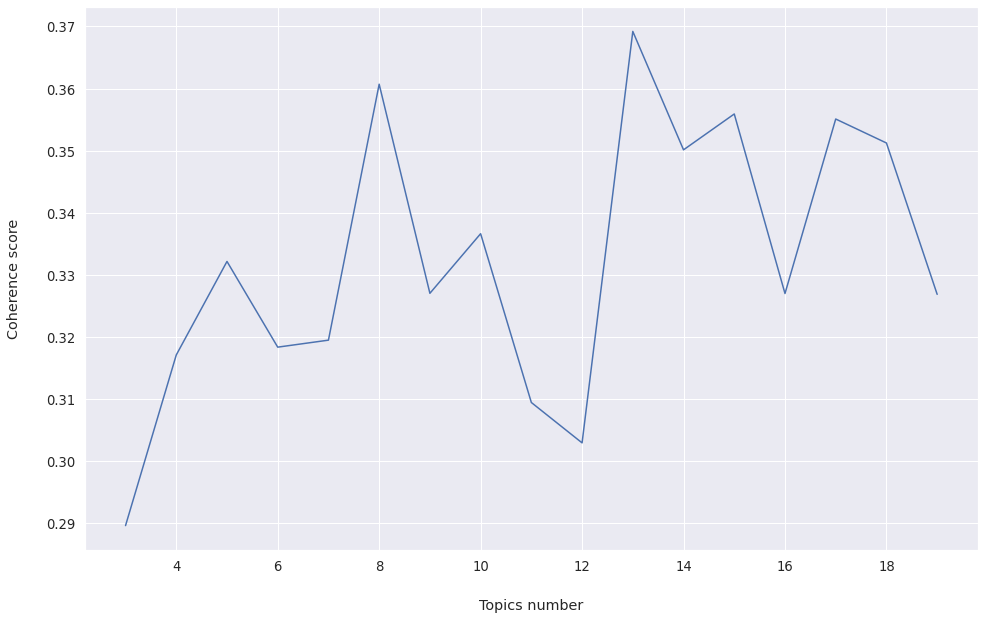

In [165]:
fig0, ax0 = plt.subplots(figsize=(16,10))
sns.lineplot(x=nums, y=scores, ax=ax0)
ax0.set_xlabel('Topics number', labelpad=25)
ax0.set_ylabel('Coherence score', labelpad=25)

In [166]:
lda_o_12 = LDAmulti(corpus, id2word=id_map, num_topics=13, passes=5, random_state=34, minimum_probability=0.04)
# minimum_probability=0.05 

In [ ]:
lda_o_12.print_topics()

In [86]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [167]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_o_12, corpus, corpus_dict)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.245018  0.160436       1        1  14.740243
1     -0.226374 -0.040872       2        1  11.871719
2     -0.188798 -0.017598       3        1   8.850749
4     -0.077185  0.135829       4        1   7.668100
7     -0.037402 -0.233579       5        1   7.185721
6      0.108804 -0.139038       6        1   7.126752
8      0.154614 -0.116782       7        1   6.899563
10    -0.096282 -0.170037       8        1   6.626612
9      0.219222  0.035486       9        1   6.271549
5      0.056280 -0.018391      10        1   5.984619
11    -0.044837  0.126321      11        1   5.931786
3      0.267457  0.087019      12        1   5.591192
0      0.109518  0.191206      13        1   5.251395, topic_info=                      Term          Freq         Total Category  logprob  \
1164          автоцистерна  14935.000000  14935.000000  Default  30.0000   
7064    топливозаправочный  14328.000000  14328.000000  Default  29.0000   
1614                полном  14391.000000  14391.000000  Default  28.0000   
774   посторонние_предметы   8710.000000   8710.000000  Default  27.0000   
2395            соблюдение  10029.000000  10029.000000  Default  26.0000   
...                    ...           ...           ...      ...      ...   
178            трубопровод    625.590211   6743.894137  Topic13  -4.9908   
1701      скоростной_режим    415.510528   1074.289116  Topic13  -5.4000   
1633              эстакада    441.148404   1623.921305  Topic13  -5.3401   
84                  осмотр    476.408623   6736.814351  Topic13  -5.2632   
856              соблюдать    475.867754  10291.819687  Topic13  -5.2643   

      loglift  
1164  30.0000  
7064  29.0000  
1614  28.0000  
774   27.0000  
2395  26.0000  
...       ...  
178    0.5690  
1701   1.9968  
1633   1.6435  
84     0.2976  
856   -0.1273  

[816 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
5785      3  0.999121          covid
5785     11  0.000390          covid
7824      6  0.996954            ftl
592       1  0.000251            абк
592       2  0.001254            абк
...     ...       ...            ...
1730      7  0.030860           этаж
6764      9  0.998326  южной_стороны
591       5  0.766174           ящик
591       8  0.232065           ящик
591       9  0.001029           ящик

[2641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 2, 3, 5, 8, 7, 9, 11, 10, 6, 12, 4, 1])

In [288]:
sentence = df.precedent[183975]
convert = ' '.join([no_punct(t.lemma_) for t in lemma_rus(sentence.lower()) if t.lemma_ not in stop_words and t.text.strip() not in punctuation])
check_doc = Sparse2Corpus(vect.transform([convert]), documents_columns=False)

p = lda_o_12[check_doc]
# print([(i + 1, j) for (i, j) in p])
print(list(p))
print(sentence)

[[(1, 0.21364266), (8, 0.26449254), (12, 0.3936449)]]
Осуществление швартовных, якорных операций. При выполнении были соблюдены все меры согласно ППБ, использовано одобренное оборудование, СИЗ.


In [226]:
lda_o_8 = LDAmulti(corpus, id2word=id_map, num_topics=8, passes=5, random_state=34, minimum_probability=0.04)

In [227]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_o_8, corpus, corpus_dict)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.173954 -0.052810       1        1  15.846026
1     -0.131966 -0.114584       2        1  14.313524
7      0.201329  0.027528       3        1  14.236127
0     -0.222415 -0.069141       4        1  12.363889
4      0.032031  0.263976       5        1  11.853401
3      0.298780 -0.233431       6        1  11.001784
5      0.110549  0.162155       7        1  10.565088
6     -0.114354  0.016307       8        1   9.820162, topic_info=                    Term          Freq         Total Category  logprob  \
1164        автоцистерна  15745.000000  15745.000000  Default  30.0000   
7064  топливозаправочный  15112.000000  15112.000000  Default  29.0000   
19              водитель  13210.000000  13210.000000  Default  28.0000   
1614              полном  13473.000000  13473.000000  Default  27.0000   
1615               объём  10825.000000  10825.000000  Default  26.0000   
...                  ...           ...           ...      ...      ...   
3277            передачи    992.269138   2388.226400   Topic8  -5.1554   
24             безопасно   1198.217954   4593.752342   Topic8  -4.9668   
4053            действие   1185.534209   4889.637332   Topic8  -4.9775   
4861                меры   1007.140285   2932.440232   Topic8  -5.1405   
1865            действия    997.890648   5731.068278   Topic8  -5.1498   

      loglift  
1164  30.0000  
7064  29.0000  
19    28.0000  
1614  27.0000  
1615  26.0000  
...       ...  
3277   1.4424  
24     0.9769  
4053   0.9038  
4861   1.2520  
1865   0.5727  

[581 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
5785      7  0.999722  covid
7824      3  0.997680    ftl
592       1  0.000801    абк
592       2  0.002136    абк
592       3  0.325721    абк
...     ...       ...    ...
591       1  0.002074   ящик
591       2  0.000691   ящик
591       3  0.865751   ящик
591       5  0.000691   ящик
591       7  0.130692   ящик

[1656 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 8, 1, 5, 4, 6, 7])

In [314]:
sent = 'Сотрудник заболел covid-19'
sent = ''.join([s for s in sent if not s.isdigit()])
conv = ' '.join([no_punct(t.lemma_) for t in lemma_rus(sent.lower()) if t.lemma_ not in stop_words and t.text.strip() not in punctuation])
chec = Sparse2Corpus(vect.transform([conv]), documents_columns=False)

p = lda_o_8[chec]
print(list(p), end='\n\n')
print(conv)

[[(0, 0.06250051), (1, 0.06250051), (2, 0.06250051), (3, 0.06250051), (4, 0.06250051), (5, 0.5624964), (6, 0.06250051), (7, 0.06250051)]]

заболеть covid


In [308]:
print(lda_o_8.print_topics()[5])
# print(lda_o_8.print_topics()[1])

(5, '0.017*"covid" + 0.016*"пункт" + 0.015*"контрольный" + 0.015*"очки" + 0.013*"время" + 0.012*"маски" + 0.010*"установки" + 0.010*"защитные" + 0.010*"груз" + 0.009*"подрядный"')
